In [ ]:
!pip install split-folders
import splitfolders
from google.colab import drive
drive.mount('/content/drive')
splitfolders.ratio("/content/drive/MyDrive/PhDProject/colon_image_sets",
            output="splitted_data",
            seed=42,
            ratio=(.7, .2, .1),
            group_prefix=None,
            move=False)

Mounted at /content/drive


Copying files: 10000 files [04:29, 37.06 files/s]


In [ ]:
import tensorflow as tf

def fire_module(x, squeeze_channels, expand1x1_channels, expand3x3_channels, dilation=1):
    x = tf.keras.layers.Conv2D(squeeze_channels, kernel_size=1, activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)  # Add Batch Normalization after the first Conv2D
    x = tf.keras.layers.Conv2D(expand1x1_channels, kernel_size=1, activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)  # Add Batch Normalization after the second Conv2D
    x = tf.keras.layers.Conv2D(expand3x3_channels, kernel_size=3, padding='same', dilation_rate=dilation, activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)  # Add Batch Normalization after the third Conv2D
    return x

def SqueezeNet1_2_dilation(input_shape, num_classes):
    input_tensor = tf.keras.layers.Input(shape=input_shape)

    x = tf.keras.layers.Conv2D(96, kernel_size=7, strides=2, padding='same', activation='relu')(input_tensor)
    x = tf.keras.layers.MaxPooling2D(pool_size=3, strides=2)(x)

    x = fire_module(x, 16, 64, 64, dilation=1)
    x = fire_module(x, 16, 64, 64, dilation=1)
    x = fire_module(x, 32, 128, 128, dilation=1)

    x = tf.keras.layers.MaxPooling2D(pool_size=3, strides=2)(x)

    x = fire_module(x, 32, 128, 128, dilation=2)
    x = fire_module(x, 48, 192, 192, dilation=2)
    x = fire_module(x, 48, 192, 192, dilation=2)
    x = fire_module(x, 64, 256, 256, dilation=2)

    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    output_tensor = tf.keras.layers.Dense(num_classes, activation='softmax')(x)

    model = tf.keras.Model(inputs=input_tensor, outputs=output_tensor)

    return model



In [ ]:
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Assuming 'create_squeezenet_dilated_residual' function returns the model architecture
model = SqueezeNet1_2_dilation(input_shape=(224, 224, 3), num_classes=2)
# Define the optimizer and loss function
optimizer = RMSprop()
loss_function = CategoricalCrossentropy()

# Compile the model
model.compile(optimizer=optimizer, loss=loss_function, metrics=['accuracy'])

# Data Preprocessing and Data Augmentation for training data
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255.0,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

train_generator = train_datagen.flow_from_directory(
    "/content/splitted_data/train",
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

# Data Preprocessing for validation data
val_datagen = ImageDataGenerator(
    rescale=1.0 / 255.0
)

val_generator = val_datagen.flow_from_directory(
    "/content/splitted_data/val",
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

# Training the model with validation data
epochs = 50
steps_per_epoch = len(train_generator)
validation_steps = len(val_generator)

try:
    history = model.fit(
        train_generator,
        epochs=epochs,
        steps_per_epoch=steps_per_epoch,
        validation_data=val_generator,
        validation_steps=validation_steps
    )
except Exception as e:
    print("An error occurred during training:", str(e))

# Plot the training and validation losses
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Time')
plt.legend()
plt.show()


Found 7000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.
Epoch 1/50
219/219 [==============================] - 296s 1s/step - loss: 0.2686 - accuracy: 0.9126 - val_loss: 3.6554 - val_accuracy: 0.5000
Epoch 2/50
219/219 [==============================] - 282s 1s/step - loss: 0.0708 - accuracy: 0.9736 - val_loss: 2.8292 - val_accuracy: 0.5000
Epoch 3/50
219/219 [==============================] - 285s 1s/step - loss: 0.0414 - accuracy: 0.9859 - val_loss: 4.5748 - val_accuracy: 0.5000
Epoch 4/50
219/219 [==============================] - 293s 1s/step - loss: 0.0315 - accuracy: 0.9900 - val_loss: 0.7320 - val_accuracy: 0.6490
Epoch 5/50
219/219 [==============================] - 310s 1s/step - loss: 0.0224 - accuracy: 0.9930 - val_loss: 4.2847 - val_accuracy: 0.5005
Epoch 6/50
219/219 [==============================] - 283s 1s/step - loss: 0.0242 - accuracy: 0.9923 - val_loss: 3.7861 - val_accuracy: 0.6875
Epoch 7/50
219/219 [==============================] - 339s

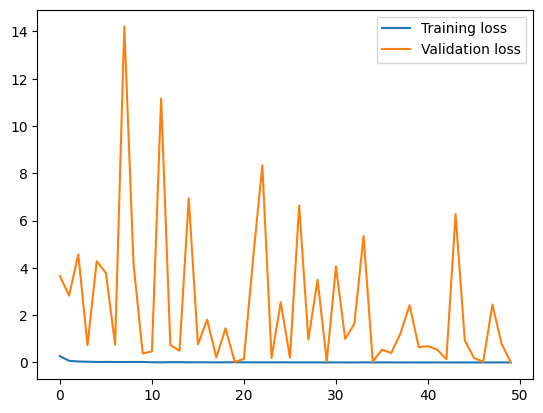

In [ ]:
import matplotlib.pyplot as plt
# Plot the training and validation losses
plt.plot(history.history['loss'],label = 'Training loss')
plt.plot(history.history['val_loss'], label = 'Validation loss')
#plt.title('loss')
plt.legend()
plt.show()

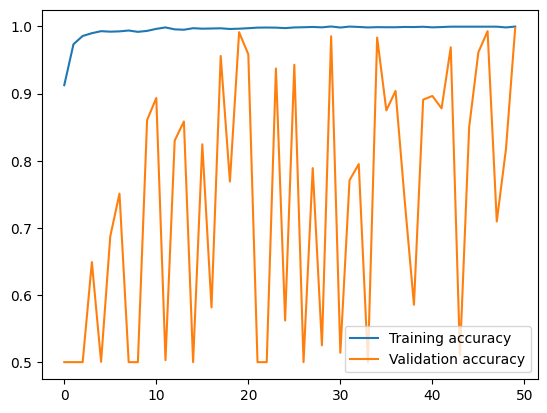

In [ ]:
# Both Validation and Training accuracy is shown here

plt.plot(history.history['accuracy'], label='Training accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
#plt.title('Accuracy')
plt.legend()
plt.show()

In [ ]:
test_set = val_datagen.flow_from_directory(
    "/content/splitted_data/test",
    target_size=(224, 224),
    batch_size=8,
    class_mode='categorical'
)

Found 1000 images belonging to 2 classes.


In [ ]:
# CHECKING THE CONFUSION MATRIX

import numpy as np # linear algebra
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
Y_pred = model.predict(test_set)
y_pred = np.argmax(Y_pred ,axis =1)


125/125 [==============================] - 9s 67ms/step


In [ ]:
print('Classification Report')
target_names = ['aca','n']
print(classification_report(test_set.classes, y_pred, target_names=target_names))

Classification Report
              precision    recall  f1-score   support

         aca       0.49      0.49      0.49       500
           n       0.49      0.49      0.49       500

    accuracy                           0.49      1000
   macro avg       0.49      0.49      0.49      1000
weighted avg       0.49      0.49      0.49      1000



In [ ]:
loss, acc = model.evaluate_generator(test_set, len(test_set))

print ("\n\n================================\n\n")
print ("Loss: {}".format(loss))
print ("Accuracy: {0:.2f} %".format(acc * 100))
print ("\n\n================================\n\n")

test_set.reset()

<ipython-input-17-9a3d6d22a8aa>:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  loss, acc = model.evaluate_generator(test_set, len(test_set))






Loss: 0.0020904531702399254
Accuracy: 99.90 %






In [ ]:
result = model.evaluate(test_set,batch_size=128)
print("test_loss, test accuracy",result)

125/125 [==============================] - 9s 68ms/step - loss: 0.0021 - accuracy: 0.9990
test_loss, test accuracy [0.0020904541015625, 0.9990000128746033]


In [ ]:
preds = model.predict(test_set,verbose=1)
predictions = preds.copy()
predictions[predictions <= 0.5] = 0
predictions[predictions > 0.5] = 1

125/125 [==============================] - 8s 67ms/step


In [ ]:

#Confusion Matrix and Classification Report
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

#Y_pred = model.predict_generator(validation_generator, nb_validation_samples //
#batch_size+1)
y_pred = np.argmax(preds, axis=1)

print('Confusion Matrix')
print(confusion_matrix(test_set.classes, y_pred))

Confusion Matrix
[[254 246]
 [247 253]]


In [ ]:
print('Classification Report')
target_names = [ 'Colon Benign','Colon Adenocarcinoma']
print(classification_report(test_set.classes, y_pred, target_names=target_names))

Classification Report
                      precision    recall  f1-score   support

        Colon Benign       0.51      0.51      0.51       500
Colon Adenocarcinoma       0.51      0.51      0.51       500

            accuracy                           0.51      1000
           macro avg       0.51      0.51      0.51      1000
        weighted avg       0.51      0.51      0.51      1000



In [ ]:
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score

precision_score(test_set.classes, y_pred) , recall_score(test_set.classes, y_pred) ,  f1_score(test_set.classes, y_pred)

(0.5070140280561122, 0.506, 0.5065065065065065)

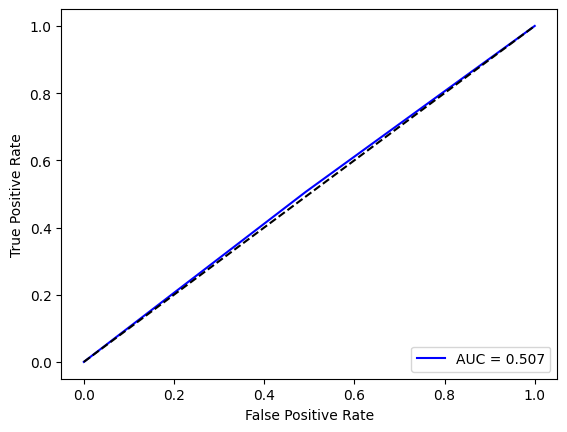

In [ ]:
import sklearn.metrics as metrics
fpr, tpr, threshold = metrics.roc_curve(test_set.classes, y_pred)
roc_auc = metrics.auc(fpr, tpr)
import matplotlib.pyplot as plt
#plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.3f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'k--')
# plt.xlim([0, 1])
# plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
#plt.title('ROC curve')

plt.show()

<Axes: >

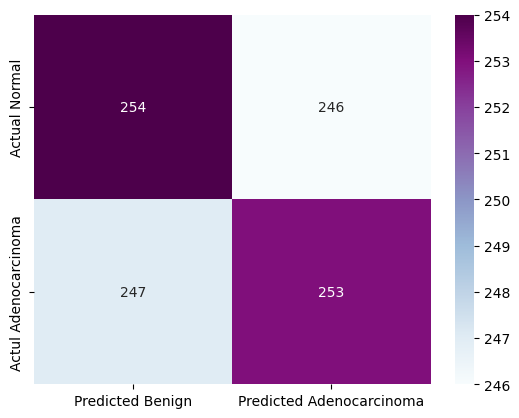

In [ ]:
import pandas as pd
from sklearn.metrics import classification_report,confusion_matrix
cm = pd.DataFrame(data=confusion_matrix( y_true= test_set.classes, y_pred= y_pred, labels=[0, 1]), index=["Actual Normal", "Actul Adenocarcinoma"],columns=["Predicted Benign", "Predicted Adenocarcinoma"])
import seaborn as sns
sns.heatmap(cm,annot=True,fmt="d",cmap="BuPu")

In [ ]:
pip install tflops

In [ ]:
import tensorflxow as tf
from tflops import get_flops

# Assuming you have already created and compiled your model
model = your_model_function()

# Print the FLOPs
flops = get_flops(model)
print("FLOPs:", flops)